# 中阶API示范

In [1]:
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

## 线性回归模型

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

In [3]:
# 样本数量
n = 400
# 生成测试用数据集
X = 10 * torch.rand([n, 2],) - 5.0
w0 = torch.tensor([[2.0], [-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal(0.0, 2.0, size=[n, 1])

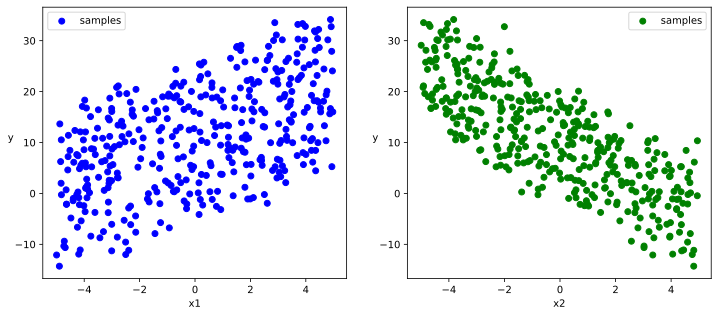

In [4]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 5))

ax1 = plt.subplot(121)
ax1.scatter(X[:, 0].numpy(), Y[:, 0].numpy(), c='b', label='samples')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1].numpy(), Y[:, 0].numpy(), c='g', label='samples')
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

plt.show()

In [5]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

ds = TensorDataset(X, Y)
dl = DataLoader(dataset=ds, batch_size=10, shuffle=True)

In [6]:
model = nn.Linear(2, 1)
model.loss_func = nn.MSELoss()
model.optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [7]:
def train_step(model, features, labels):
    pred = model(features)
    loss = model.loss_func(pred, labels)
    loss.backward()
    model.optimizer.step()
    model.optimizer.zero_grad()
    return loss.item()

feature, labels = next(iter(dl))
train_step(model, feature, labels)

171.85922241210938

In [8]:
def train_model(model, epochs):
    for epoch in range(1, epochs + 1):
        for feature, labels in dl:
            loss = train_step(model, feature, labels)
        if epoch % 50 == 0:
            printbar()
            w = model.state_dict()['weight']
            b = model.state_dict()['bias']
            print("epoch =", epoch,"loss = ", loss)
            print("w =", w)
            print("b =", b)

train_model(model, epochs=200)


================================================================================2021-02-06 16:22:24
epoch = 50 loss =  4.336575031280518
w = tensor([[ 2.0045, -2.9759]])
b = tensor([10.0096])

================================================================================2021-02-06 16:22:25
epoch = 100 loss =  8.340845108032227
w = tensor([[ 2.0979, -3.0484]])
b = tensor([9.9708])

================================================================================2021-02-06 16:22:25
epoch = 150 loss =  4.837945938110352
w = tensor([[ 2.0142, -2.9836]])
b = tensor([9.9593])

================================================================================2021-02-06 16:22:26
epoch = 200 loss =  3.2733352184295654
w = tensor([[ 2.0165, -3.0328]])
b = tensor([10.0071])


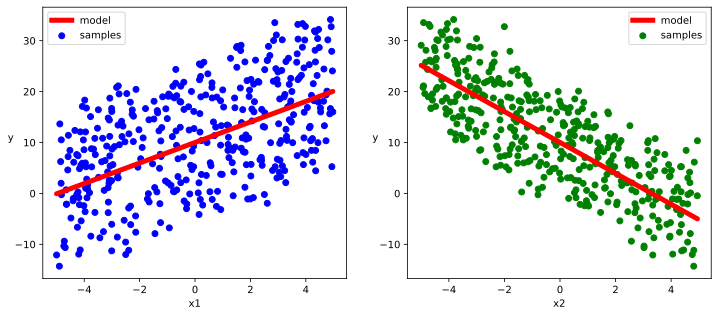

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w, b = model.state_dict()["weight"], model.state_dict()["bias"]

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c="b", label="samples")
ax1.plot(X[:, 0], w[0, 0] * X[:, 0] + b[0], "-r", linewidth=5.0, label="model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c="g", label="samples")
ax2.plot(X[:, 1], w[0, 1] * X[:, 1] + b[0], "-r", linewidth=5.0, label="model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation = 0)

plt.show()

## DNN二分类模型

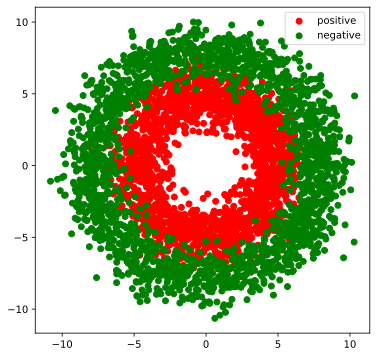

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

#正负样本数量
n_positive, n_negative = 2000, 2000

r_p = 5.0 + torch.normal(0.0, 1.0, size=[n_positive, 1])
theta_p = 2 * np.pi * torch.rand([n_positive, 1])
Xp = torch.cat([r_p * torch.cos(theta_p), r_p * torch.sin(theta_p)], axis=1)
Yp = torch.ones_like(r_p)

r_n = 8.0 + torch.normal(0.0, 1.0, size=[n_negative, 1])
theta_n = 2 * np.pi * torch.rand([n_negative, 1])
Xn = torch.cat([r_n * torch.cos(theta_n), r_n * torch.sin(theta_n)], axis=1)
Yn = torch.zeros_like(r_n)

X = torch.cat([Xp, Xn], axis=0)
Y = torch.cat([Yp, Yn], axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c='r')
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c='g')
plt.legend(['positive', 'negative'])

In [12]:
#构建输入数据管道

ds = TensorDataset(X, Y)
dl = DataLoader(ds, batch_size = 10, shuffle=True)

In [13]:
import torch.nn.functional as F

class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))

        return y

    def loss_func(self, y_pred, y_true):
        return nn.BCELoss()(y_pred, y_true)

    def metric_func(self, y_pred, y_true):
        y_pred = torch.where(y_pred > 0.5, torch.ones_like(y_pred, dtype=torch.float32), torch.zeros_like(y_pred, dtype=torch.float32))
        acc = torch.mean(1 - torch.abs(y_true - y_pred))
        return  acc

    @property
    def optimizer(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = DNNModel()

In [14]:
(features, labels) = next(iter(dl))
pred = model(features)

loss = model.loss_func(pred, labels)
metric = model.metric_func(pred, labels)

print("init loss:", loss.item())
print("init metric:", metric.item())

init loss: 0.9027146100997925
init metric: 0.30000001192092896


In [16]:
def train_step(model, features, labels):
    pred = model.forward(features)
    loss = model.loss_func(pred, labels)
    metric = model.metric_func(pred, labels)

    loss.backward()

    model.optimizer.step()
    model.optimizer.zero_grad()

    return loss.item(),metric.item()


features, labels = next(iter(dl))
train_step(model, features, labels)

(0.8106265068054199, 0.5)

In [17]:
def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        loss_list, metric_list = [],[]
        for features, labels in dl:
            loss_cur, metric_cur = train_step(model, features, labels)
            loss_list.append(loss_cur)
            metric_list.append(metric_cur)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)

        if epoch%100 == 0:
            printbar()
            print("epoch =", epoch, "loss = ", loss, "metric = ", metric)

train_model(model, epochs = 300)


================================================================================2021-02-06 16:39:23
epoch = 100 loss =  0.24714554677881095 metric =  0.9274999928474427

================================================================================2021-02-06 16:39:56
epoch = 200 loss =  0.2832627254591262 metric =  0.9252499923110008

================================================================================2021-02-06 16:40:30
epoch = 300 loss =  0.30632302803363815 metric =  0.9274999928474427


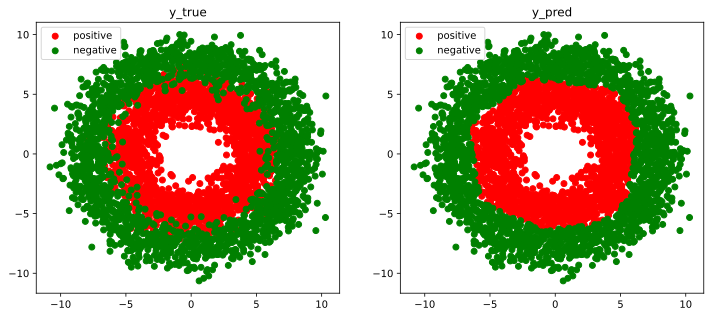

In [18]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = (12,5))
ax1.scatter(Xp[:,0], Xp[:,1], c="r")
ax1.scatter(Xn[:,0], Xn[:,1], c = "g")
ax1.legend(["positive", "negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X) >= 0.5)]
Xn_pred = X[torch.squeeze(model.forward(X) < 0.5)]

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1], c = "r")
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1], c = "g")
ax2.legend(["positive", "negative"]);
ax2.set_title("y_pred");